In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.boston_housing.load_data()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [4]:
# Normalization
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)

X_train = (X_train-X_mean)/X_std
X_test = (X_test-X_mean)/X_std
print(X_train[0])

dim_target = 12

# X_train_1D = X_train[:,dim_target] 이렇게 불러오면 matrix로 인식을 못해서 에러가 뜸 인위적으로 한차원을 만들어 줘야 함.
# print(X_train_1D.shape)
X_train_1D = tf.expand_dims(X_train[:,dim_target], axis = 1)
print(X_train_1D.shape)
X_test_1D = tf.expand_dims(X_test[:,dim_target], axis = 1)
Y_train_1D = tf.expand_dims(Y_train, axis = 1)
Y_test_1D = tf.expand_dims(Y_test, axis = 1)

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]
(404, 1)


In [5]:
def plot_graph(X, Y, X_hat = None, Y_hat = None, str_title = None):
    fig = plt.figure(figsize = (8,6))
    
    if str_title is not None:
        plt.title(str_title, fontsize = 20, pad = 20)
        
    plt.plot(X,Y, ls = 'none', marker = 'o')
    
    if X_hat is not None and Y_hat is not None:
        plt.plot(X_hat, Y_hat)
        
    plt.tick_params(axis= 'both', labelsize = 14)

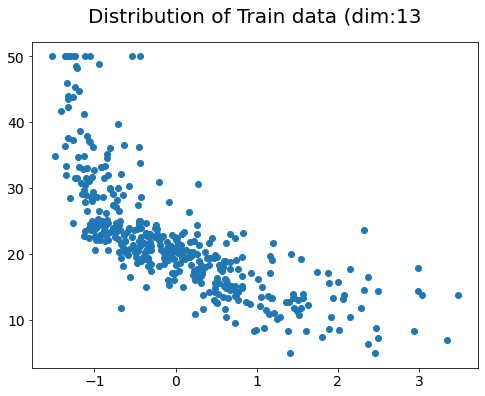

In [6]:
plot_graph(X_train_1D,Y_train, str_title = "Distribution of Train data (dim:{}".format(dim_target+1))

In [7]:
Xmat_T_Xmat = tf.matmul(tf.transpose(X_train_1D), X_train_1D) # X^t X
weight = tf.matmul(
    tf.matmul(tf.linalg.inv(Xmat_T_Xmat),
             tf.transpose(X_train_1D)),
            Y_train_1D
    )

In [8]:
print(weight.shape)
print(weight)

(1, 1)
tf.Tensor([[-6.72258852]], shape=(1, 1), dtype=float64)


In [9]:
loss = tf.math.sqrt(tf.reduce_mean((Y_test-tf.squeeze(tf.matmul(X_test_1D, weight)))**2)).numpy()
print(loss)

23.4293024538165


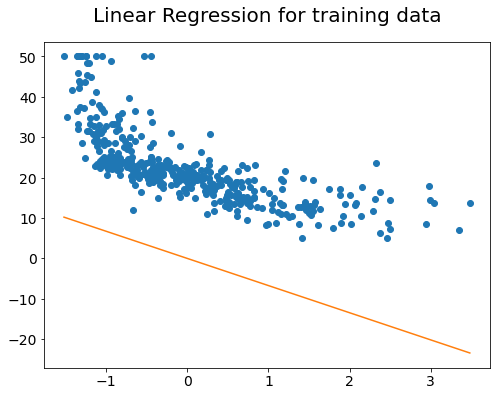

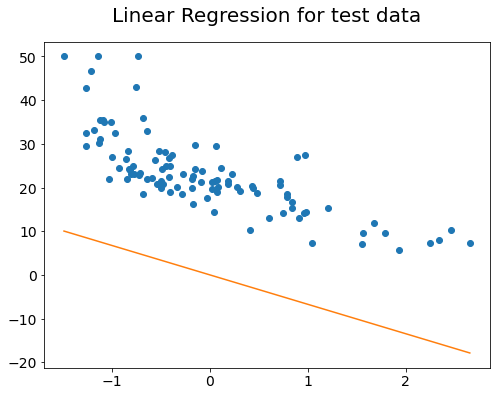

In [11]:
X_train_for_line = np.expand_dims(np.linspace(np.min(X_train_1D), np.max(X_train_1D), 100), axis = 1)
X_test_for_line = np.expand_dims(np.linspace(np.min(X_test_1D), np.max(X_test_1D), 100), axis = 1)

plot_graph(X_train_1D, Y_train, X_hat = X_train_for_line, Y_hat = tf.matmul(X_train_for_line, weight),
          str_title = "Linear Regression for training data")

plot_graph(X_test_1D, Y_test, X_hat = X_test_for_line, Y_hat = tf.matmul(X_test_for_line, weight),
          str_title = "Linear Regression for test data")

In [12]:
def feature_f(X, degree):
    num_X = tf.shape(X)[0]
    Phi = tf.ones([num_X,1], dtype = tf.dtypes.float64)
    
    for i in range(degree):
        Phi = Phi * X
        if i == degree-1:
            Phi = tf.concat([feature_f(X, degree-1), Phi], axis = 1)
            
    return Phi

In [13]:
num_degree = 3

Phi_train = feature_f(X_train_1D, num_degree)
Phi_test = feature_f(X_test_1D, num_degree)
Phi_Xtrain_for_line = feature_f(X_train_for_line, num_degree)
Phi_Xtest_for_line = feature_f(X_test_for_line, num_degree)

Phi_T_Phi = tf.matmul(tf.transpose(Phi_train), Phi_train) 
weight_f = tf.matmul(
    tf.matmul(tf.linalg.inv(Phi_T_Phi),
             tf.transpose(Phi_train)),
            Y_train_1D
    )

loss = tf.math.sqrt(tf.reduce_mean((Y_test - tf.squeeze(tf.matmul(Phi_test, weight_f)))**2)).numpy()

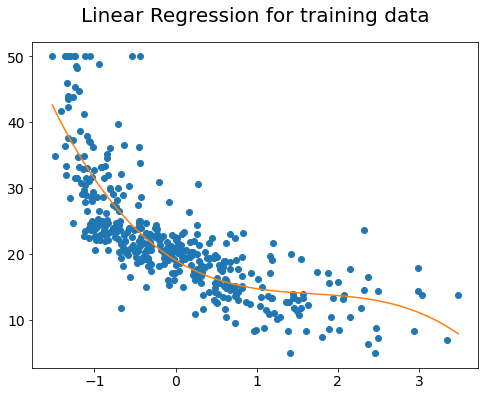

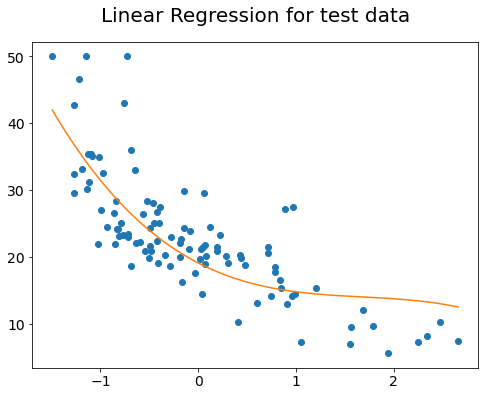

In [14]:
plot_graph(X_train_1D, Y_train, X_hat = X_train_for_line, Y_hat = tf.matmul(Phi_Xtrain_for_line, weight_f),
          str_title = "Linear Regression for training data")
plot_graph(X_test_1D, Y_test, X_hat = X_test_for_line, Y_hat = tf.matmul(Phi_Xtest_for_line, weight_f),
          str_title = "Linear Regression for test data")

In [15]:
# gradiant descent

(H, W) = weight_f.shape
weight_gd = tf.Variable(np.random.randn(H,W), dtype = tf.dtypes.float64)

def RMSE(y_pred, y_true):
    return tf.math.sqrt(tf.reduce_mean(tf.square(tf.squeeze(y_pred)-y_true)))

In [16]:
learning_rate = 0.001
optimizer = tf.optimizers.SGD(learning_rate)

def run_optimization():
    with tf.GradientTape() as g: # gradient 값을 가지고 있음.
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred, Y_train)
        
    gradients = g.gradient(loss, [weight_gd])
    optimizer.apply_gradients(zip(gradients, [weight_gd]))

In [17]:
training_steps = 30000
display_step = 5000

for step in range(1,training_steps+1):
    run_optimization()
    
    if step % display_step == 0:
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred, Y_train)
        print("step : ", step, "loss : ", loss.numpy(), "weight : ", weight_gd.numpy())

step :  5000 loss :  18.604809780911946 weight :  [[ 3.26270807]
 [-2.75079608]
 [ 2.35270445]
 [-0.16805493]]
step :  10000 loss :  12.056269721997449 weight :  [[ 7.71117417]
 [-4.15415284]
 [ 5.47945569]
 [-1.24527357]]
step :  15000 loss :  7.826432568044011 weight :  [[11.55106254]
 [-5.25779186]
 [ 7.56004892]
 [-1.98169484]]
step :  20000 loss :  6.411631720284817 weight :  [[14.00956676]
 [-5.85031569]
 [ 8.05794956]
 [-2.18486527]]
step :  25000 loss :  5.9853944753952755 weight :  [[15.35588543]
 [-6.12156338]
 [ 7.65181406]
 [-2.07171288]]
step :  30000 loss :  5.7507812057888 weight :  [[16.20651368]
 [-6.30132774]
 [ 7.04256274]
 [-1.87810653]]


In [18]:
pred = tf.matmul(Phi_test, weight_gd)
loss = RMSE(pred, Y_test).numpy()
print('loss : ', loss)

loss :  6.468917006817036


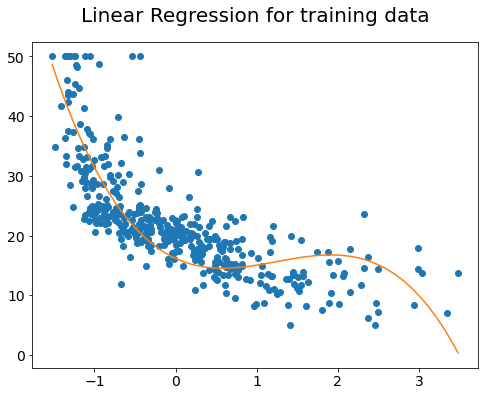

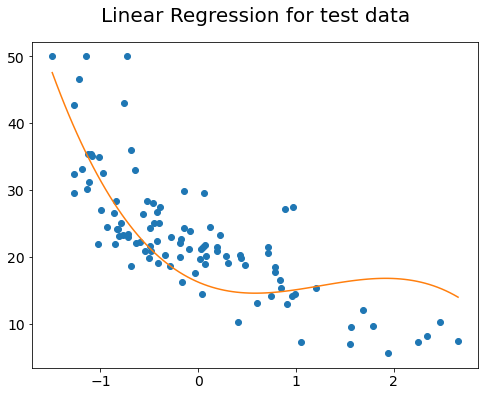

In [19]:
plot_graph(X_train_1D, Y_train, X_hat = X_train_for_line, Y_hat = tf.matmul(Phi_Xtrain_for_line, weight_gd),
          str_title = "Linear Regression for training data")
plot_graph(X_test_1D, Y_test, X_hat = X_test_for_line, Y_hat = tf.matmul(Phi_Xtest_for_line, weight_gd),
          str_title = "Linear Regression for test data")